In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm

pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol, h5_name
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()

                              date                   spot_price  \
0     /date_2024_10_11/date_string  /date_2024_10_11/spot_price   
1     /date_2024_10_10/date_string  /date_2024_10_10/spot_price   
2     /date_2024_10_09/date_string  /date_2024_10_09/spot_price   
3     /date_2024_10_08/date_string  /date_2024_10_08/spot_price   
4     /date_2024_10_07/date_string  /date_2024_10_07/spot_price   
...                            ...                          ...   
4216  /date_2008_01_08/date_string  /date_2008_01_10/spot_price   
4217  /date_2008_01_07/date_string  /date_2008_01_09/spot_price   
4218  /date_2008_01_04/date_string  /date_2008_01_08/spot_price   
4219  /date_2008_01_03/date_string  /date_2008_01_07/spot_price   
4220  /date_2008_01_02/date_string  /date_2008_01_04/spot_price   

                   raw_data_key               surface_key  \
0     /date_2024_10_11/raw_data  /date_2024_10_11/surface   
1     /date_2024_10_10/raw_data  /date_2024_10_10/surface   
2     /date_

# available time-series

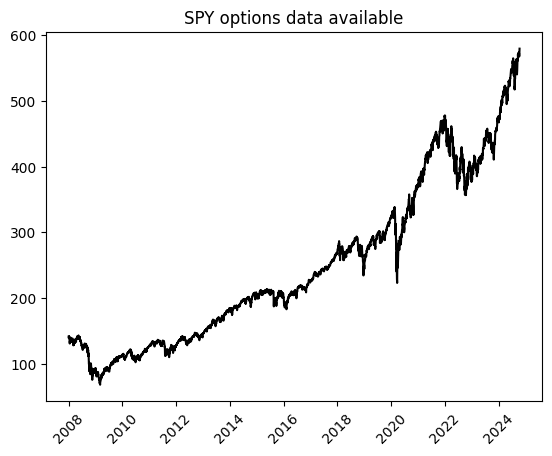

<Figure size 640x480 with 0 Axes>

In [3]:
spot_keys = keys_df.loc[:,['spot_price','date']].dropna()
spots = pd.Series()
store.open()
for i,row in spot_keys.iterrows():
    spot_price = float(store[row['spot_price']].iloc[0])
    date = str(store[row['date']].iloc[0])
    date = datetime.strptime(date,'%Y-%m-%d')
    spots.loc[date] = spot_price
store.close()
plt.figure()
plt.plot(spots,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data available')
plt.show()
plt.clf()

# volatility surface query

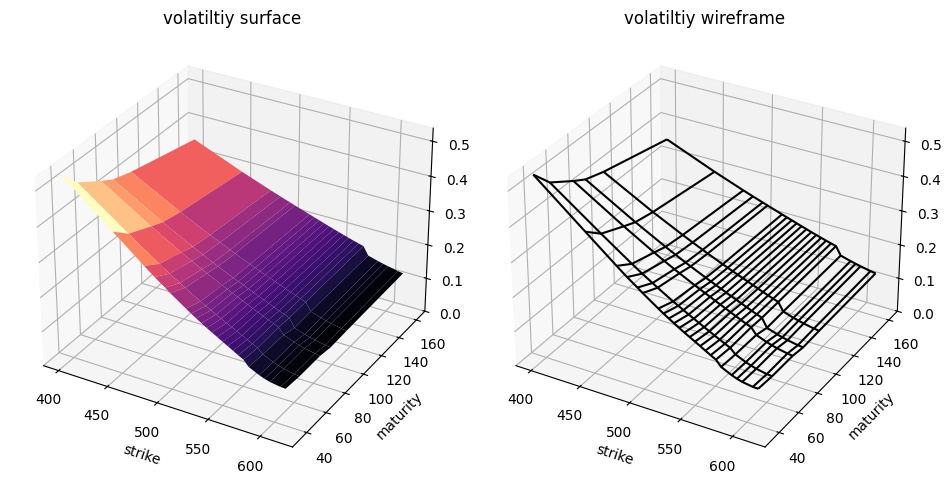

<Figure size 640x480 with 0 Axes>

In [4]:
from historical_av_plot_vol_surface import plot_vol_surface
surface_keys = keys_df.dropna(subset='surface_key').iloc[:1]
while True:
    try:
        store.open()
        surface = store[surface_keys.iloc[0]['surface_key']]
        break
    except OSError:
        time.sleep(2)
    finally:
        store.close()

plot_vol_surface(surface)

# calibrations

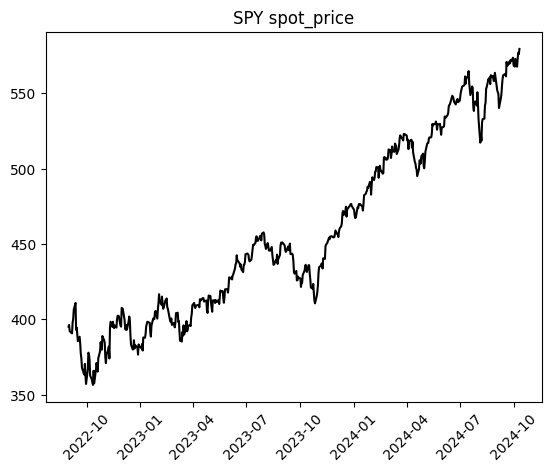

<Figure size 640x480 with 0 Axes>

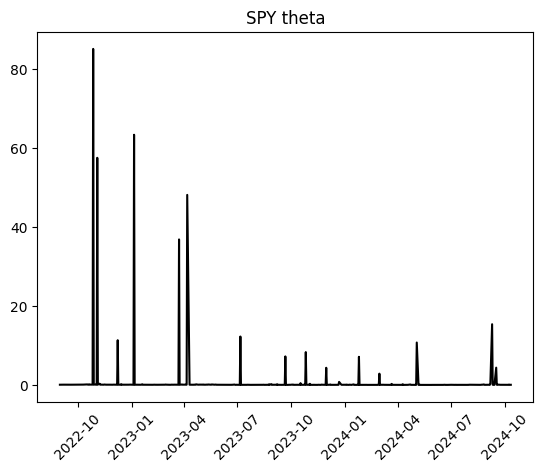

<Figure size 640x480 with 0 Axes>

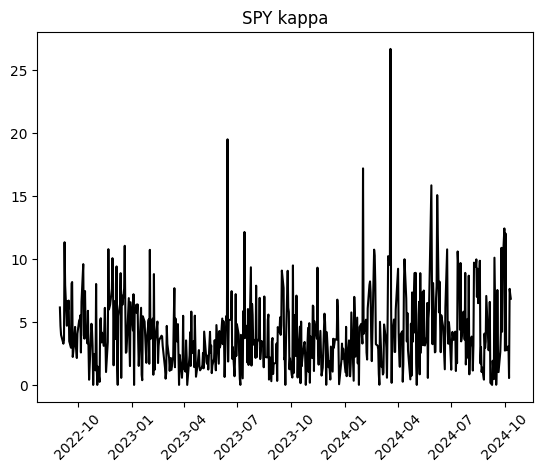

<Figure size 640x480 with 0 Axes>

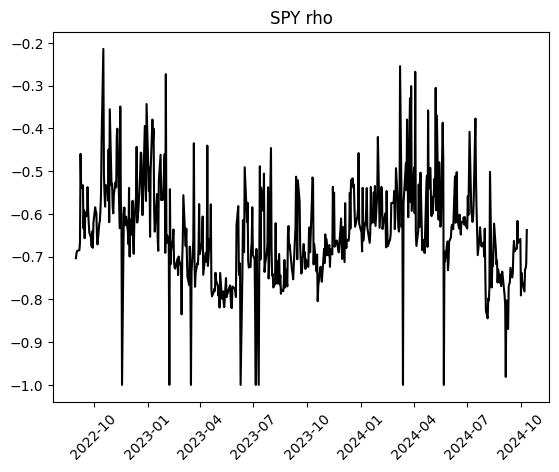

<Figure size 640x480 with 0 Axes>

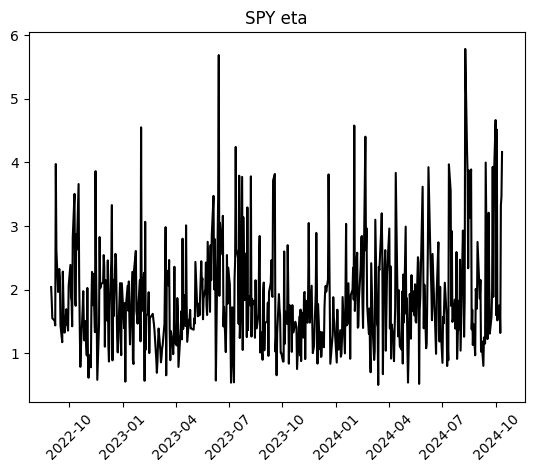

<Figure size 640x480 with 0 Axes>

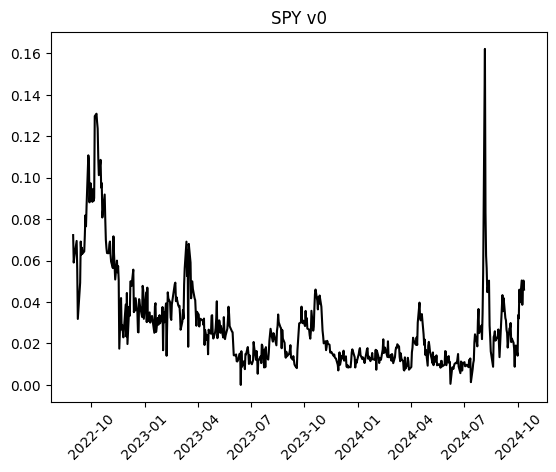


                    calculation_date   strike_price   market_price  \
count                        1212924 1212924.000000 1212924.000000   
mean   2023-10-02 04:49:19.438844672     433.702633      38.089230   
min              2022-08-31 00:00:00      85.000000       0.000000   
25%              2023-03-14 00:00:00     360.000000       0.360000   
50%              2023-10-11 00:00:00     431.000000       7.120000   
75%              2024-04-22 00:00:00     508.000000      45.200000   
max              2024-10-11 00:00:00     830.000000     461.370000   
std                              NaN     117.083180      64.576935   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 1212924.000000    1212924.000000 1212924.000000  1212924.000000   
mean        0.241732        106.907432     460.734543        0.040000   
min         0.006110         30.000000     356.560000        0.040000   
25%         0.142690         50.000000     407.260000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [5]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_key','parameter_key'])
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
            parameters[row['date']] = store[row['parameter_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

In [6]:
calibrations

,strike_price,w,market_price,volatility,days_to_maturity,spot_price,risk_free_rate,dividend_rate,theta,kappa,eta,rho,v0,moneyness,black_scholes,heston_price,error
calculation_date,,,,,,,,,,,,,,,,,
2024-10-11,260.000000,call,320.910000,0.245830,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.229154,320.575350,320.594510,0.019159
2024-10-11,260.000000,put,0.040000,0.868900,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.551399,0.040439,0.019159,-0.021280
2024-10-11,265.000000,call,308.750000,0.241990,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.187094,315.594492,315.616372,0.021880
2024-10-11,265.000000,put,0.040000,0.849380,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,-0.542772,0.040437,0.021880,-0.018556
2024-10-11,270.000000,call,303.990000,0.238140,35,579.580000,0.040000,0.000000,0.056462,6.843009,4.161733,-0.637668,0.045975,1.146593,310.613633,310.638560,0.024927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,705.000000,put,0.000000,0.636130,142,395.180000,0.040000,0.000000,0.074254,6.150670,2.040143,-0.703573,0.072295,0.783997,306.128120,298.935186,-7.192934
2022-08-31,710.000000,call,0.010000,0.277140,142,395.180000,0.040000,0.000000,0.074254,6.150670,2.040143,-0.703573,0.072295,-0.443408,0.011545,0.001091,-0.010454
2022-08-31,710.000000,put,0.000000,0.642530,142,395.180000,0.040000,0.000000,0.074254,6.150670,2.040143,-0.703573,0.072295,0.796650,311.090590,303.857849,-7.232741
